In [1]:
%load_ext autoreload
%autoreload 2
import priors
import matplotlib.pyplot as plt
import numpy as np
from confusion_noise import get_threshold_and_conf_noise_for_powerlaw
from tqdm import tqdm
from scipy.stats import powerlaw
import jax.numpy as jnp
import numpyro
from numpyro import distributions as dist
from numpyro import infer
import jax
import jax
jax.config.update("jax_enable_x64", True)
from jax.scipy.integrate import trapezoid
from quadax import quadgk

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax.scipy.special import logsumexp

In [2]:
def generate_data(key, Nbins, fmin, fmax, sigma_n, N_avg, gamma, A0):
    """
    Generate synthetic data.
    
    Parameters
    ----------
    gamma : float
        Power law index. p(f) ∝ f^gamma (e.g., gamma=-4 means more sources at low f)
    A0 : float
        Intrinsic amplitude Ã (same for all sources)
    """
    keys = jax.random.split(key, 5)
    
    # Frequency grid
    delta_f = (fmax - fmin) / Nbins
    f = jnp.linspace(fmin + delta_f/2, fmax - delta_f/2, Nbins)
    
    # Number of sources
    N = jax.random.poisson(keys[0], N_avg)
    
    # Source frequencies: p(f) ∝ f^gamma
    u = jax.random.uniform(keys[1], (N,))
    f_sources = (fmin**(gamma + 1) + u * (fmax**(gamma + 1) - fmin**(gamma + 1)))**(1 / (gamma + 1))
    
    # Phases
    phi_sources = jax.random.uniform(keys[2], (N,), minval=-jnp.pi, maxval=jnp.pi)
    
    # Amplitudes: A = Ã × (f/fmin)^(2/3)
    A_sources = A0 * (f_sources / fmin)**(2/3)
    
    # Complex waveforms
    h_sources = A_sources * jnp.exp(1j * phi_sources)
    
    # Bin and sum
    bin_indices = jnp.floor((f_sources - fmin) / delta_f).astype(int)
    bin_indices = jnp.clip(bin_indices, 0, Nbins - 1)
    H_total = jnp.zeros(Nbins, dtype=complex).at[bin_indices].add(h_sources)
    
    # Complex noise: each component has variance sigma_n^2 / 2
    noise = (jax.random.normal(keys[3], (Nbins,)) + 1j * jax.random.normal(keys[4], (Nbins,))) * sigma_n / jnp.sqrt(2)
    
    data = H_total + noise
    
    return data, f, {'N': N, 'f_sources': f_sources, 'A0': A0, 'delta_f': delta_f}

In [3]:
gamma = -4
fmin = 1e-4
fmax = 1e-2
sigma_n = 1.111
A0 = 3
Navg = int(1e6)
Nbins = 1000

def wf(A0, f, phi, fmin=1e-3):
    return A0 * (f / fmin)**(2/3) * np.exp(1j * phi)

def get_total_strain_per_bin(fmin, fmax, Nbins, fs, phis, A0, sigma_n):
    delta_f = (fmax - fmin) / Nbins
    fmin_vals = np.linspace(fmin, fmax-delta_f, Nbins)
    fmax_vals = fmin_vals + delta_f
    fcenters = (fmin_vals + fmax_vals) / 2.
    Hs = []
    wfs = wf(A0 * np.ones(fs.size), fs, phis, fmin=fmin)
    bin_labels = np.floor((fs - fmin) / delta_f)
    for i in range(Nbins):
        Hs.append(np.sum((bin_labels==i) * wfs))
    noise = (np.random.randn(Nbins) + 1j * np.random.randn(Nbins)) * sigma_n / np.sqrt(2)
    Hs = np.array(Hs) + noise
    return fcenters, np.array(Hs)

def get_fs(fmin, fmax, N):
    return priors.sample_power_law_bounded(-gamma, fmin, fmax, N)

def get_phis(N):
    return np.random.uniform(-np.pi, np.pi, size=N)

In [29]:
fs = get_fs(fmin, fmax, Navg)
phis = get_phis(Navg)
fcenters, Hs_data = get_total_strain_per_bin(fmin, fmax, Nbins, fs, phis, A0, sigma_n)

In [30]:
# def generate_data(key, Nbins, fmin, fmax, sigma_n, N_sources, gamma_true, A0_true):
# Hs_data, fcenters, _ = generate_data(jax.random.key(0), Nbins, fmin, fmax, sigma_n, Navg, gamma, A0)

/Users/pmeyers/miniforge3/envs/gb_spike_slab/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/pmeyers/miniforge3/envs/gb_spike_slab/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


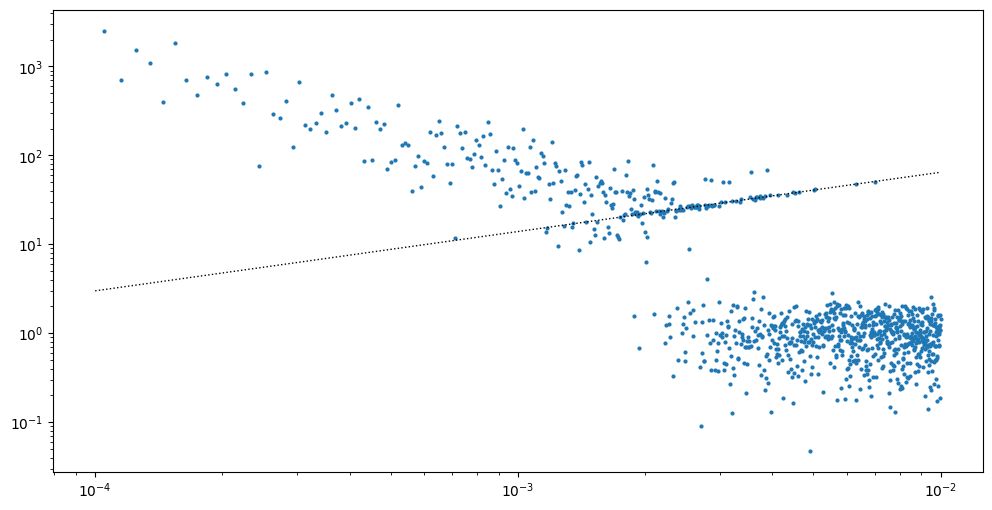

In [31]:
plot_fs = np.linspace(fmin, fmax, 1000)
plt.figure(figsize=(12, 6))
plt.scatter(fcenters, np.abs(Hs_data), s=4)
# plt.scatter(fcenters2, np.abs(Hs_data2), s=4)
plt.yscale("log")
plt.xscale("log")
plt.plot(plot_fs, wf(A0, plot_fs, 0, fmin=fmin), c='k', ls=':', lw=1)
plt.show()

In [32]:
def alpha_func(f, f_res, sres):
    return 0.5 * (1 + jnp.tanh((jnp.log(f) - jnp.log(f_res)) / sres))

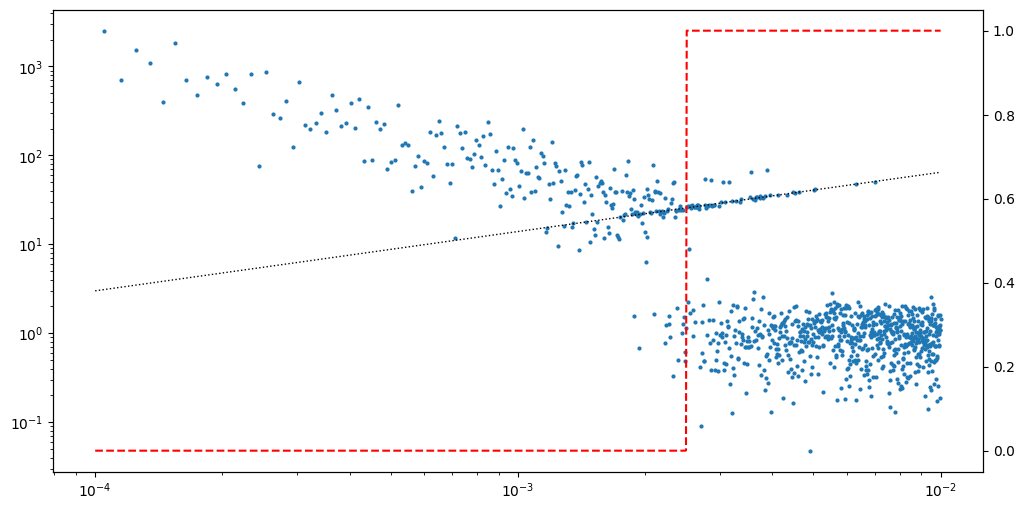

In [33]:
plot_fs = np.linspace(fmin, fmax, 1000)
plt.figure(figsize=(12, 6))
plt.scatter(fcenters, np.abs(Hs_data), s=4)
plt.yscale("log")
plt.xscale("log")
plt.plot(plot_fs, wf(A0, plot_fs, 0, fmin=fmin), c='k', ls=':', lw=1)
ax2 = plt.twinx()
ax2.plot(plot_fs, alpha_func(plot_fs, 2.5e-3, 2e-4), c='r', ls='--')
plt.show()

In [34]:


# Optional: for numerical integration
# from quadax import quadgk  # or use your preferred quadrature


# =============================================================================
# Helper Functions
# =============================================================================

def power_law_pdf(f, gamma, fmin, fmax):
    """
    Power-law PDF: p(f|γ) ∝ f^γ, normalized over [fmin, fmax]
    """
    norm = (fmax**(gamma + 1) - fmin**(gamma + 1)) / (gamma + 1)
    return f**gamma / norm


def alpha_func(f, f_res, s_res):
    """
    Resolvability function: probability source at frequency f is resolved.
    Sigmoid transition centered at f_res with width s_res.
    """
    return 0.5 * (1 + jnp.tanh((jnp.log(f) - jnp.log(f_res)) / s_res))


def compute_pres(gamma, f_res, s_res, fmin, fmax, num_points=1000):
    """
    Probability that a source is resolvable, integrated over frequency distribution.
    
    p_res = ∫ p(f|γ) α(f) df
    
    Uses trapezoidal rule for simplicity. Replace with quadgk for higher accuracy.
    """
    f_grid = jnp.linspace(fmin, fmax, num_points)
    p_f = power_law_pdf(f_grid, gamma, fmin, fmax)
    alpha = alpha_func(f_grid, f_res, s_res)
    integrand = p_f * alpha
    p_res = jnp.trapezoid(integrand, f_grid)
    return p_res


def compute_confusion_noise(f, N_tot, mean_Atilde2, gamma, f_res, s_res, fmin, fmax, delta_f):
    """
    Confusion noise variance at each frequency bin.
    
    The expected number of unresolved sources in a bin at frequency f is:
        n_unres(f) = N_tot × p(f|γ) × δf × (1 - α(f))
    
    Each contributes power |h|² = Ã² × (f/f_min)^(4/3)
    
    So:
        σ_B²(f) = N_tot × p(f|γ) × δf × (1 - α(f)) × ⟨Ã²⟩ × (f/f_min)^(4/3)
    """
    p_f = power_law_pdf(f, gamma, fmin, fmax)
    alpha = alpha_func(f, f_res, s_res)
    freq_scaling = (f / fmin)**(4/3)
    
    sigma2_b = N_tot * p_f * delta_f * (1 - alpha) * mean_Atilde2 * freq_scaling
    return sigma2_b


def log_whittle_likelihood(data, H, sigma2_tot):
    """
    Whittle likelihood for complex frequency-domain data.
    
    p(d|H, σ²) = ∏_i (1/σ²_i) exp(-|d_i - H_i|² / σ²_i)
    
    Returns log-likelihood (sum over bins).
    """
    residual2 = jnp.abs(data - H)**2
    logl = -jnp.sum(jnp.log(sigma2_tot) + residual2 / sigma2_tot)
    return logl


def log_whittle_likelihood_per_bin(data, H, sigma2_tot):
    """
    Per-bin Whittle log-likelihood (for Gibbs updates).
    """
    residual2 = jnp.abs(data - H)**2
    logl = -jnp.log(sigma2_tot) - residual2 / sigma2_tot
    return logl


# =============================================================================
# Main Model
# =============================================================================

def model(data, Nbins, f, sigma_n, fmin, fmax):
    """
    Hierarchical model for LISA-like GW source detection.
    
    Jointly infers:
    - Population hyperparameters (N_tot, gamma, amplitude distribution)
    - Resolvability curve (f_res, s_res)
    - Per-bin source parameters (amplitude, phase)
    - Source indicators z_i (via Gibbs sampling)
    
    The confusion noise is computed deterministically from population parameters.
    """
    delta_f = f[1] - f[0]
    
    # =========================================================================
    # Population Hyperparameters
    # =========================================================================
    
    # Total number of sources (log-uniform prior)
    log10_Ntot = numpyro.sample("log10_Ntot", dist.Uniform(4, 8))
    N_tot = 10**log10_Ntot
    
    # Frequency distribution: power law with spectral index gamma
    gamma = numpyro.sample("gamma", dist.Uniform(-5, -1))
    
    # Intrinsic amplitude distribution (log-normal for positivity)
    # log(Ã) ~ Normal(μ, σ²)  =>  Ã ~ LogNormal
    log10_Ap = numpyro.sample("log10_Ap", dist.Uniform(-2, 2))
    sigma_logA = numpyro.sample("sigma_logA", dist.Uniform(0.01, 2))
    
    # Convert to natural log parameterization
    mu_logA = jnp.log(10**log10_Ap)  # median in log space
    
    # Resolvability curve parameters
    f_res = numpyro.sample("f_res", dist.Uniform(fmin, fmax))
    s_res = numpyro.sample("s_res", dist.Uniform(0, 0.5))
    
    # =========================================================================
    # Derived Population Quantities
    # =========================================================================
    
    # Probability of resolvability
    p_res = compute_pres(gamma, f_res, s_res, fmin, fmax)
    numpyro.deterministic("p_res", p_res)
    
    # Expected number of resolvable sources (for Gibbs prior)
    N1 = p_res * N_tot
    numpyro.deterministic("N1", N1)
    
    # Mean squared amplitude for confusion noise
    # For log-normal: ⟨Ã²⟩ = exp(2μ + 2σ²)
    mean_Atilde2 = jnp.exp(2 * mu_logA + 2 * sigma_logA**2)
    numpyro.deterministic("mean_Atilde2", mean_Atilde2)
    
    # Confusion noise (deterministic function of population parameters)
    sigma2_b = compute_confusion_noise(
        f, N_tot, mean_Atilde2, gamma, f_res, s_res, fmin, fmax, delta_f
    )
    numpyro.deterministic("sigma2_b", sigma2_b)
    
    # Total noise variance
    sigma2_tot = sigma2_b + sigma_n**2
    numpyro.deterministic("sigma2_tot", sigma2_tot)
    
    # =========================================================================
    # Per-Bin Source Parameters
    # =========================================================================
    
    # Intrinsic amplitudes from population distribution
    with numpyro.plate("bins", Nbins):
        log_Atilde_tmp = numpyro.sample(
            "log_Atilde_tmp", 
            dist.Normal(0, 1)
        )
        log_Atilde = numpyro.deterministic('log_Atilde', mu_logA + log_Atilde_tmp * sigma_logA)
        # Phases (uniform)
        phi = numpyro.sample("phi", dist.Uniform(-jnp.pi, jnp.pi))
        
        # Source indicators (placeholder prior; Gibbs handles actual sampling)
        z_i = numpyro.sample("z_i", dist.Bernoulli(0.5))
    
    # Convert to observed amplitude (frequency scaling)
    Atilde = jnp.exp(log_Atilde)
    A = Atilde * (f / fmin)**(2/3)
    numpyro.deterministic("A", A)
    
    # Complex templates
    H = A * jnp.exp(1j * phi)
    numpyro.deterministic("H", H)
    
    # =========================================================================
    # Likelihood
    # =========================================================================
    
    logl = log_whittle_likelihood(data, H * z_i, sigma2_tot)
    numpyro.factor("log_like", logl)


# =============================================================================
# Gibbs Sampling Function for z_i
# =============================================================================
def make_gibbs_fn(data, f, fmin, sigma_n, rho_min=None, rho_width=1):
    """
    Factory function that creates the Gibbs sampler for z_i.
    
    Parameters
    ----------
    data : array
        Complex frequency-domain data
    f : array
        Frequency bin centers
    fmin : float
        Minimum frequency
    sigma_n : float
        Instrumental noise standard deviation
    rho_min : float, optional
        SNR threshold for resolvability. If None, no threshold is applied.
    rho_width : float, optional
        Width of soft threshold transition. Only used if rho_min is set.
        Smaller = sharper transition. Default 1.0.
    """
    
    def gibbs_fn(rng_key, gibbs_sites, hmc_sites):
        """
        Gibbs update for source indicators z_i.
        """
        z_i = gibbs_sites['z_i']
        
        # Current count of active sources (for Poisson prior)
        Nk = jnp.sum(z_i)
        N_minusk = Nk - z_i
        
        # Get relevant HMC sites
        H = hmc_sites['H']
        sigma2_tot = hmc_sites['sigma2_tot']
        N1 = hmc_sites['N1']
        
        # Compute SNR
        rho = jnp.abs(H) / jnp.sqrt(sigma2_tot)
        
        # Per-bin log-likelihoods
        logl_signal = log_whittle_likelihood_per_bin(data, H, sigma2_tot)
        logl_noise = log_whittle_likelihood_per_bin(data, jnp.zeros_like(H), sigma2_tot)
        
        # Log Bayes factor for each bin
        log_Bk = logl_signal - logl_noise
        
        # Log prior odds (Poisson prior on total count)
        log_prior_odds = jnp.log(N1) - jnp.log(N_minusk + 1)
        
        # Add soft SNR threshold to prior odds
        if rho_min is not None:
            # log(α_snr) where α_snr = sigmoid((ρ - ρ_min) / width)
            # This equals -softplus(-(ρ - ρ_min) / width)
            log_alpha_snr = -jax.nn.softplus(-(rho - rho_min) / rho_width)
            log_prior_odds = log_prior_odds + log_alpha_snr
        
        # Posterior odds and probability
        log_odds = log_Bk + log_prior_odds
        q = jax.nn.sigmoid(log_odds)
        
        # Sample new indicators
        with numpyro.plate("bins", q.shape[0]):
            numpyro.deterministic('q', q)
            numpyro.deterministic('rho', rho)
            gibbs_sites['z_i'] = numpyro.sample(
                "z_i", 
                dist.Bernoulli(q), 
                rng_key=rng_key
            )
        
        return gibbs_sites
    
    return gibbs_fn


# =============================================================================
# Run Inference
# =============================================================================

def run_inference(data, f, sigma_n, fmin, fmax, num_warmup=500, num_samples=1000, seed=0, rho_min=None, rho_width=1):
    """
    Run HMC-within-Gibbs inference.
    """
    from numpyro.infer import MCMC, NUTS, HMCGibbs
    
    Nbins = len(f)
    
    # Create Gibbs function
    gibbs_fn = make_gibbs_fn(data, f, fmin, sigma_n, rho_min=rho_min, rho_width=rho_width)
    
    # Set up HMC-Gibbs sampler
    kernel = HMCGibbs(
        NUTS(model),
        gibbs_fn=gibbs_fn,
        gibbs_sites=['z_i']
    )
    
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        progress_bar=True
    )
    
    # Run
    mcmc.run(
        jax.random.key(seed),
        data=data,
        Nbins=Nbins,
        f=f,
        sigma_n=sigma_n,
        fmin=fmin,
        fmax=fmax
    )
    
    return mcmc


# =============================================================================
# Data Generation (for testing)
# =============================================================================



In [35]:
# def run_inference(data, f, sigma_n, fmin, fmax, num_warmup=500, num_samples=1000, seed=0):
mcmc = run_inference(Hs_data, fcenters, sigma_n, fmin, fmax, num_warmup=1000, num_samples=1000, rho_min=3, rho_width=.1)

sample: 100%|██████████| 2000/2000 [00:29<00:00, 67.45it/s, 63 steps of size 5.05e-02. acc. prob=0.76]  


In [36]:
samples = mcmc.get_samples()

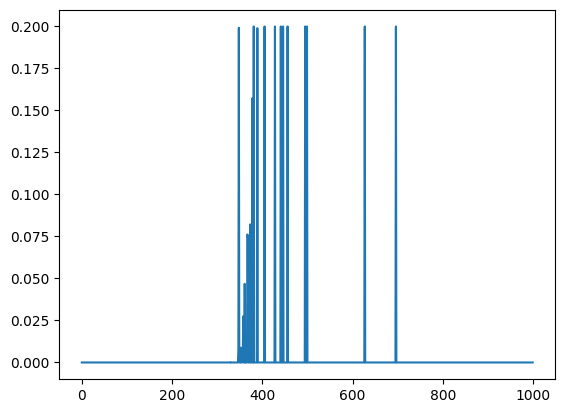

In [37]:
plt.plot(np.sum(samples['z_i'] / 5000, axis=0))

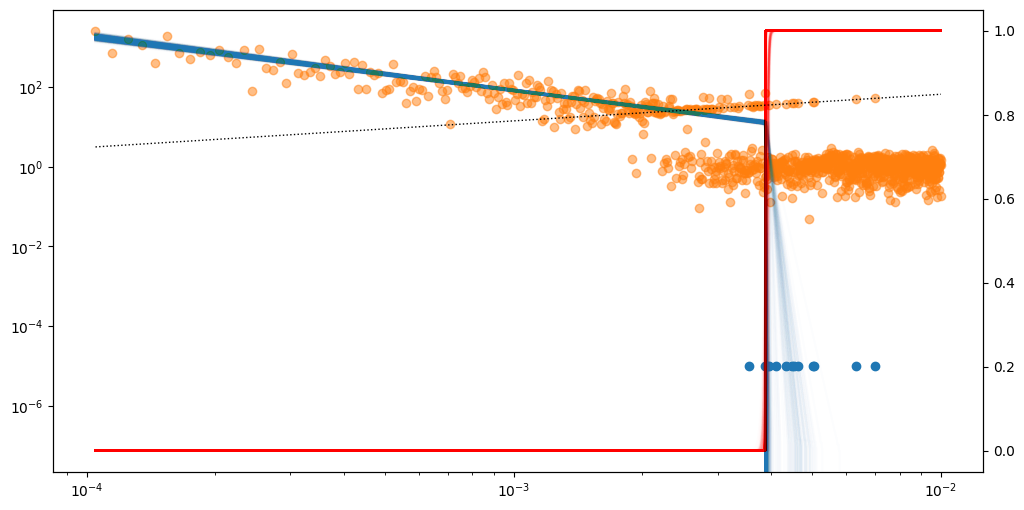

In [38]:
resolvable_mask = np.mean(samples['z_i'], axis=0) > 0.9
# print(np.mean(np.abs(samples['Hi'][:, resolvable_mask]), axis=0))
# print(fcenters[resolvable_mask])
plt.figure(figsize=(12, 6))
for ii in range(1000):
    plt.plot(fcenters, np.sqrt(samples['sigma2_b'][ii]), alpha=0.01, c='C0')
plt.xscale("log")
plt.yscale("log")
# plt.scatter(fcenters[resolvable_mask], np.median(np.abs(samples['Hi'][:, resolvable_mask]), axis=0), marker='*', s=128, c='r')
plt.plot(fcenters, np.abs(wf(A0, fcenters, 0, fmin=fmin)), c='k', ls=':', lw=1)
plt.scatter(fcenters, np.abs(Hs_data), c='C1', alpha=0.5)
plt.scatter(fcenters[resolvable_mask], np.ones(np.sum(resolvable_mask))* 1e-5)
ax2 = plt.twinx()
for ii in range(1000):
    ax2.plot(fcenters, alpha_func(fcenters, samples['f_res'][ii], samples['s_res'][ii]), alpha=0.01, c='r')
plt.show()

In [39]:
np.sum(samples['z_i'], axis=1)

Array([13, 13, 13, 13, 13, 13, 14, 16, 16, 16, 15, 15, 15, 15, 16, 16, 16,
       16, 16, 14, 13, 13, 13, 13, 14, 16, 17, 15, 16, 16, 15, 15, 15, 17,
       19, 17, 15, 16, 16, 15, 15, 15, 15, 13, 13, 13, 13, 14, 13, 13, 13,
       15, 16, 16, 15, 16, 15, 15, 15, 15, 15, 15, 15, 15, 16, 14, 14, 16,
       15, 14, 14, 13, 14, 14, 16, 17, 17, 18, 15, 15, 17, 16, 15, 15, 15,
       15, 15, 16, 15, 13, 15, 15, 13, 13, 14, 15, 14, 13, 13, 14, 15, 11,
       11, 11, 12, 11, 12, 12, 12, 13, 13, 14, 14, 14, 15, 14, 15, 15, 14,
       14, 15, 16, 14, 16, 16, 15, 16, 18, 17, 17, 17, 16, 15, 14, 13, 14,
       14, 14, 14, 14, 14, 14, 15, 13, 14, 15, 13, 14, 13, 15, 12, 13, 14,
       13, 13, 14, 13, 13, 13, 13, 12, 13, 12, 12, 13, 13, 13, 14, 14, 14,
       14, 13, 13, 13, 13, 13, 14, 13, 13, 14, 13, 15, 14, 15, 13, 14, 14,
       14, 13, 15, 13, 15, 15, 17, 17, 17, 16, 16, 15, 16, 15, 15, 17, 16,
       15, 16, 16, 18, 17, 18, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 17,
       18, 18, 19, 18, 18

(array([0.   , 0.005, 0.109, 0.224, 0.218, 0.181, 0.133, 0.074, 0.043,
        0.011, 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]),
 array([ 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
        20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5,
        31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5,
        42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5,
        53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5]),
 <BarContainer object of 51 artists>)

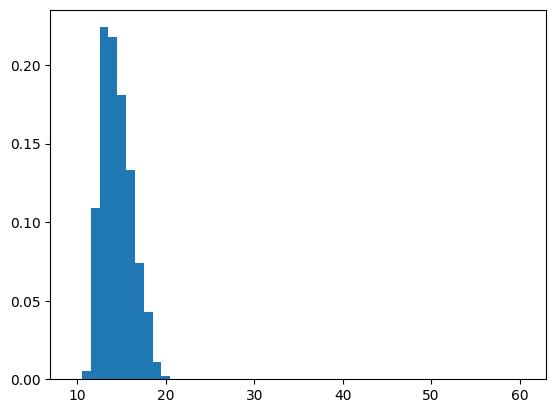

In [40]:
plt.hist(np.sum(samples['z_i'], axis=1), density=True, bins=np.linspace(9.5, 60.5, 52))

(array([  1.,   6.,  30., 109., 247., 305., 192.,  85.,  21.,   4.]),
 array([2.91237316, 2.9297904 , 2.94720764, 2.96462487, 2.98204211,
        2.99945934, 3.01687658, 3.03429382, 3.05171105, 3.06912829,
        3.08654552]),
 <BarContainer object of 10 artists>)

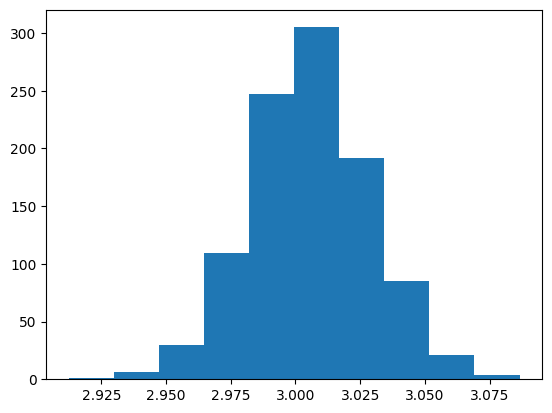

In [41]:
plt.hist(10**samples['log10_Ap'])

(array([ 13., 107., 184., 259., 204., 124.,  68.,  28.,  12.,   1.]),
 array([ 715296.77355659,  861850.19161575, 1008403.60967491,
        1154957.02773408, 1301510.44579324, 1448063.8638524 ,
        1594617.28191157, 1741170.69997073, 1887724.1180299 ,
        2034277.53608906, 2180830.95414822]),
 <BarContainer object of 10 artists>)

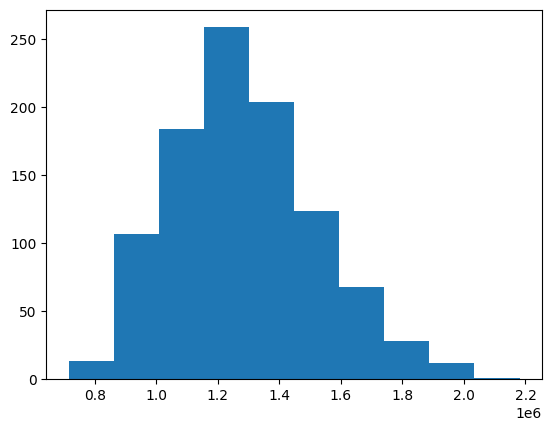

In [42]:
plt.hist(10**samples['log10_Ntot'])

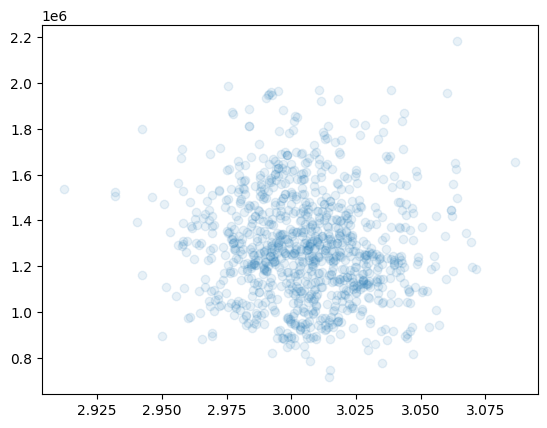

In [43]:
plt.scatter(10**samples['log10_Ap'], 10**samples['log10_Ntot'], alpha=0.1)

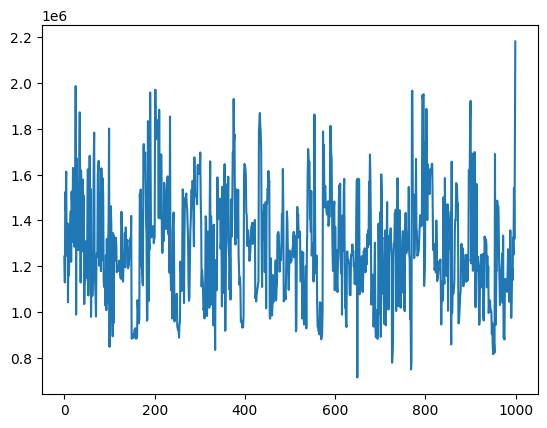

In [44]:
plt.plot(10**samples['log10_Ntot'])

(array([898.,  10.,   7.,  23.,  32.,  18.,  10.,   1.,   0.,   1.]),
 array([6.62227825e-06, 2.18551438e-03, 4.36440648e-03, 6.54329857e-03,
        8.72219067e-03, 1.09010828e-02, 1.30799749e-02, 1.52588670e-02,
        1.74377591e-02, 1.96166512e-02, 2.17955433e-02]),
 <BarContainer object of 10 artists>)

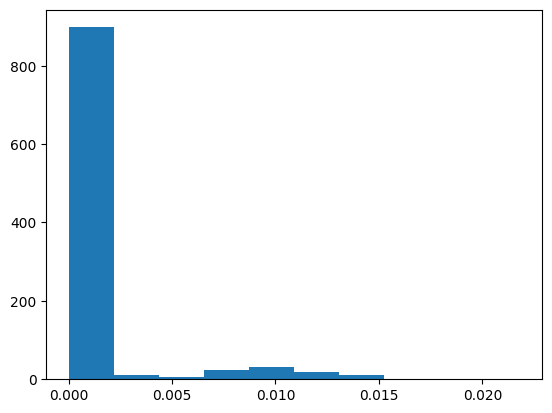

In [45]:
plt.hist(samples['s_res'])

[[14.95666545 13.28755827  9.27337526 ...  1.111       1.111
   1.111     ]
 [14.22038937 12.6366078   2.19502398 ...  1.111       1.111
   1.111     ]
 [13.73154739 12.12911375  5.91822985 ...  1.111       1.111
   1.111     ]
 ...
 [13.92336468 12.33056991  1.111      ...  1.111       1.111
   1.111     ]
 [13.53992886 11.93799321  1.111      ...  1.111       1.111
   1.111     ]
 [13.33481899 10.97444915  1.111      ...  1.111       1.111
   1.111     ]]
[[223.70184129 176.55920472  85.99548879 ...   1.234321     1.234321
    1.234321  ]
 [202.21947384 159.68385669   4.81813026 ...   1.234321     1.234321
    1.234321  ]
 [188.55539372 147.11540035  35.02544458 ...   1.234321     1.234321
    1.234321  ]
 ...
 [193.86008408 152.0429543    1.234321   ...   1.234321     1.234321
    1.234321  ]
 [183.32967359 142.51568188   1.234321   ...   1.234321     1.234321
    1.234321  ]
 [177.81739759 120.4385342    1.234321   ...   1.234321     1.234321
    1.234321  ]]


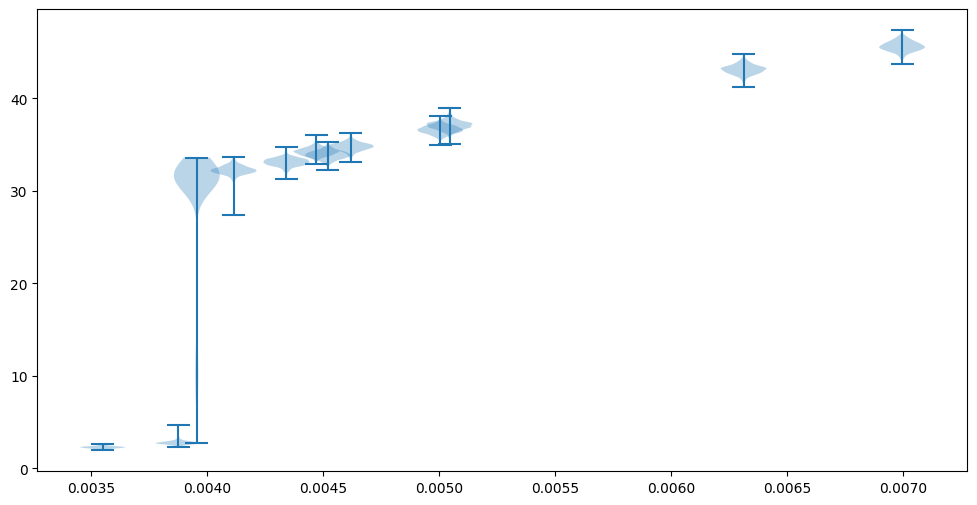

In [46]:
resolved_idxs = np.where(resolvable_mask)[0]

rhos = samples['A'][:, resolved_idxs] / np.sqrt(samples['sigma2_tot'][:, resolved_idxs])
print(np.sqrt(samples['sigma2_tot'][:, resolved_idxs]))
print(samples['sigma2_tot'][:, resolved_idxs])
plt.figure(figsize=(12, 6))
plt.violinplot(rhos, positions=fcenters[resolved_idxs], widths=20 * (fcenters[2] - fcenters[1]) * np.ones(resolved_idxs.size))
plt.show()

In [47]:
np.sum(samples['z_i'][resolved_idxs[0]])

Array(15, dtype=int64)

In [48]:
resolved_idxs

array([348, 381, 389, 405, 428, 441, 446, 456, 495, 499, 627, 696])

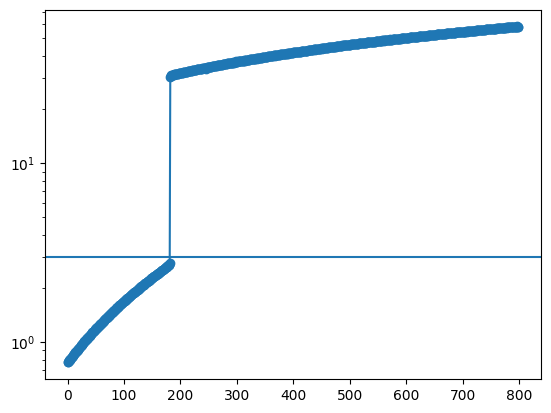

In [49]:
plt.plot(np.median(samples['A'][:, 200:] / np.sqrt(samples['sigma2_tot'][:, 200:]),axis=0),'-o')
plt.yscale("log")
ax=plt.gca()
ax.axhline(3)